In [1]:
import numpy as np
import math
import os
import csv
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import griddata
import meshio
from cc import get_cmap
from plot_cylinder import plot_cylinder
from spatial_derivatives import *

In [2]:
cmap = get_cmap(custom=False)

# Reading Files

In [3]:
# function to extract flow data from restart files

def read_data_from_csv(fname):
    try:
        with open(fname) as f:
            data_iter = csv.reader(f,delimiter=",")
            data = [row[:] for row in data_iter] # skip first iteration due to headers
        data = np.asarray(data[1:],dtype='float64')
        pid = data[:,0] # id
        X = data[:,1] # x-coordinate
        Y = data[:,2] # y-coordinate
        mir = -data[:,2] # symmetry y-coordinate
        rho = data[:,3] # density
        mx = data[:,4] # momentum in x
        my = data[:,5] # momentum in y 
        p = data[:,7] # pressure
        e = data[:,-2] # energy
        vort = data[:,-1] # vorticity
        return [pid,X,Y,rho,mx,my,p,e,vort]
    except IOError:
        print("File not accessible")

In [4]:
# data directory
data_dir="./lam_comp_air/restart/"
min_bound=0
max_bound=3000

# filename template
filenames = "restart_flow_"

# Get flow problem dimension
try:
    with open(data_dir+filenames + "00000.csv") as f:
        data_iter = csv.reader(f,delimiter=",")
        N = sum(1 for _ in data_iter) - 1
except IOError:
    print("Files not accessible")

# Number of files in directory
num_files = len(os.listdir(data_dir))

# Set subsampling option and max_size
force_subsampling = False
delay = 2000 # skipped files
subsampling = 2 # every x flow snapshot
max_size = 500 # maximum number of samples
files = num_files - delay

# check array size
if files > max_size or force_subsampling:
    if (files)//subsampling > max_size:
        array_size = max_size
    else:
        array_size = files//subsampling
else:
    array_size = files

In [5]:
# initializing data matrix
rho_arr = np.empty([N,array_size])     # density
p_arr = np.empty([N,array_size])       # pressure
vort_arr = np.empty([N,array_size])    # vorticity
e_arr = np.empty([N,array_size])       # energy
u_arr = np.empty([N,array_size])       # velocity in x
v_arr = np.empty([N,array_size])       # velocity in y
a_arr = np.empty([N,array_size])       # speed of sound

# setting computation values
gamma = 1.4
alpha = 1

# reading files fully
for i in tqdm(range(array_size)):  
    num = i * subsampling + delay
    fname = data_dir + filenames + "{:05d}".format(num) + ".csv"
    # reading file routine
    [pid,x,y,rho,mx,my,p,e,vort] = read_data_from_csv(fname)
    rho_arr[:,i] = rho
    p_arr[:,i]   = p
    vort_arr[:,i]= vort  
    e_arr[:,i]= e 
    u_arr[:,i] = np.divide(mx,rho)
    v_arr[:,i] = np.divide(my,rho)
    a_arr[:,i] = np.sqrt((gamma-1)*e*gamma)

100%|██████████| 500/500 [01:17<00:00,  6.44it/s]


# Computing POD Modes

In [6]:
# compute average components of q(u,v,a)
u_avg = np.mean(u_arr,1)
v_avg = np.mean(v_arr,1)
a_avg = np.mean(a_arr,1)

# compute fluctuating components
u_fluc = u_arr-np.repeat(np.expand_dims(u_avg,1),u_arr.shape[1],axis=1)
v_fluc = v_arr-np.repeat(np.expand_dims(v_avg,1),v_arr.shape[1],axis=1)
a_fluc = a_arr-np.repeat(np.expand_dims(a_avg,1),a_arr.shape[1],axis=1)

# compute POD modes of q(u,v,a) trough SVD
q_fluc = np.vstack((u_fluc,v_fluc,a_fluc))
q_avg = np.concatenate((u_avg,v_avg,a_avg))
U, S, Vh = np.linalg.svd(q_fluc, full_matrices=False)

In [7]:
# reconstruction threshold
epsilon = 0.97 # [0,1]
acc = 0
num = 0
while acc < epsilon:
    num+=1
    acc = sum(S[:num])/sum(S)    
print("Number of eigenvectors necessary for thresholded reconstruction: \t" + str(num))

Number of eigenvectors necessary for thresholded reconstruction: 	6


# Visualizing POD Modes and Activations

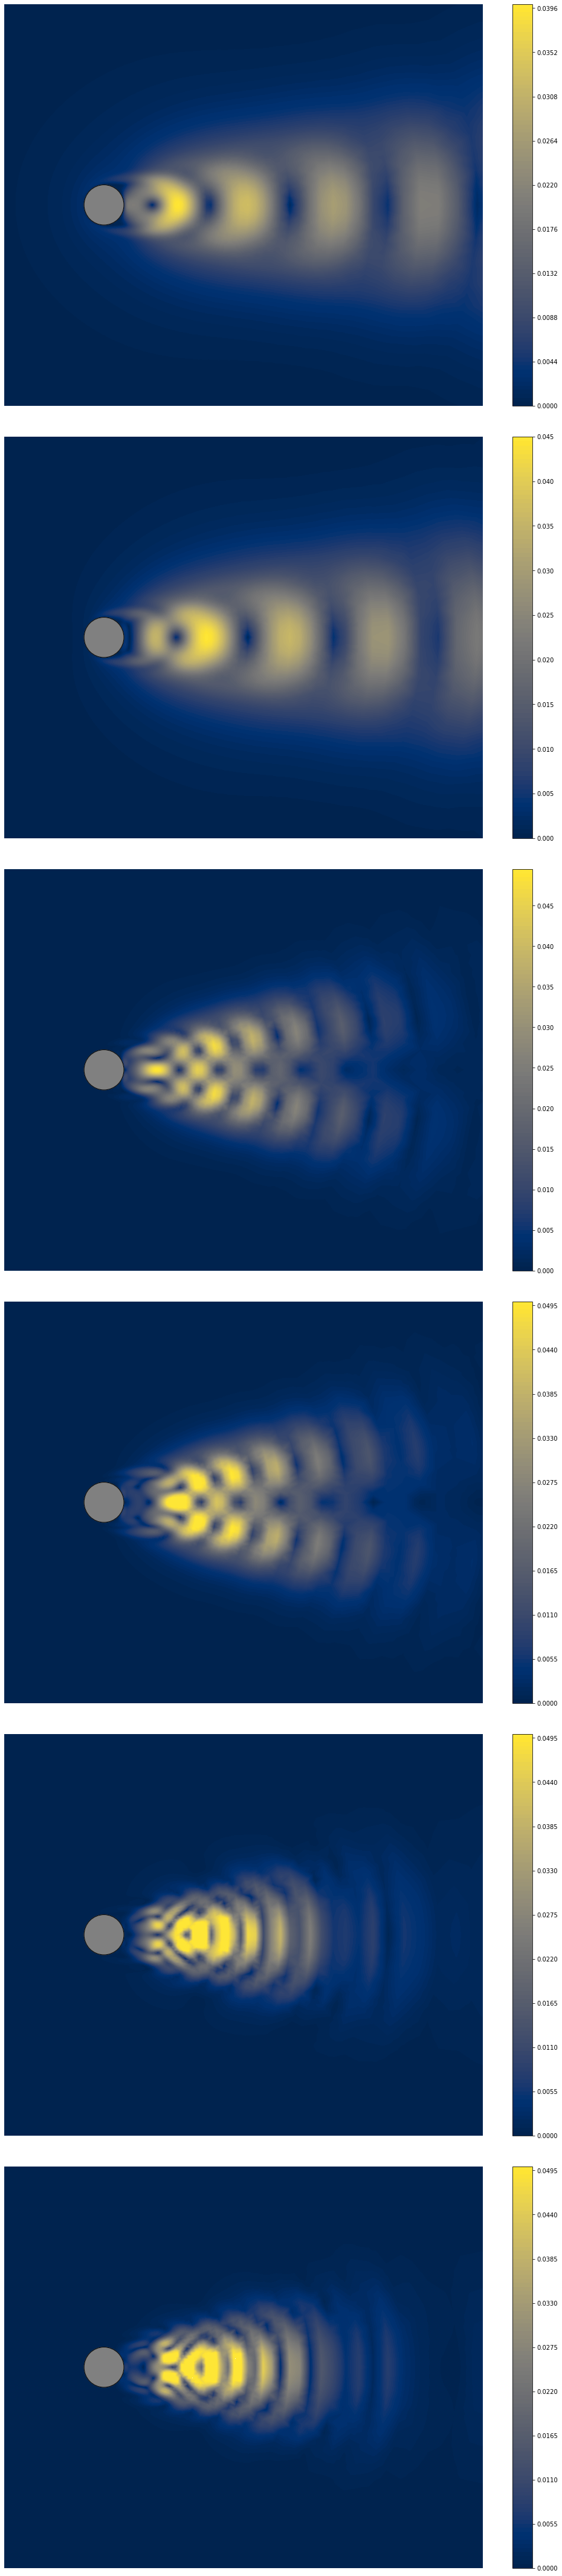

In [8]:
# plot corresponding eigenflows
fig,ax = plt.subplots(6,1,figsize=(15,60))
fig.tight_layout(pad=3.0)

for i in range(6):
    data = np.sqrt(np.multiply(U[:N,i],U[:N,i])+np.multiply(U[N:2*N,i],U[N:2*N,i]))
    plot_cylinder(x,y,data,ax=ax[i],cmap='cividis')

In [9]:
# coefficients for given timeframe t = 0,...,T
coeffs = np.matmul(np.transpose(U[:,:num]),q_fluc)

# set timestep 
dt = 0.01
t = np.linspace(0,(array_size-1)*subsampling*dt,array_size)

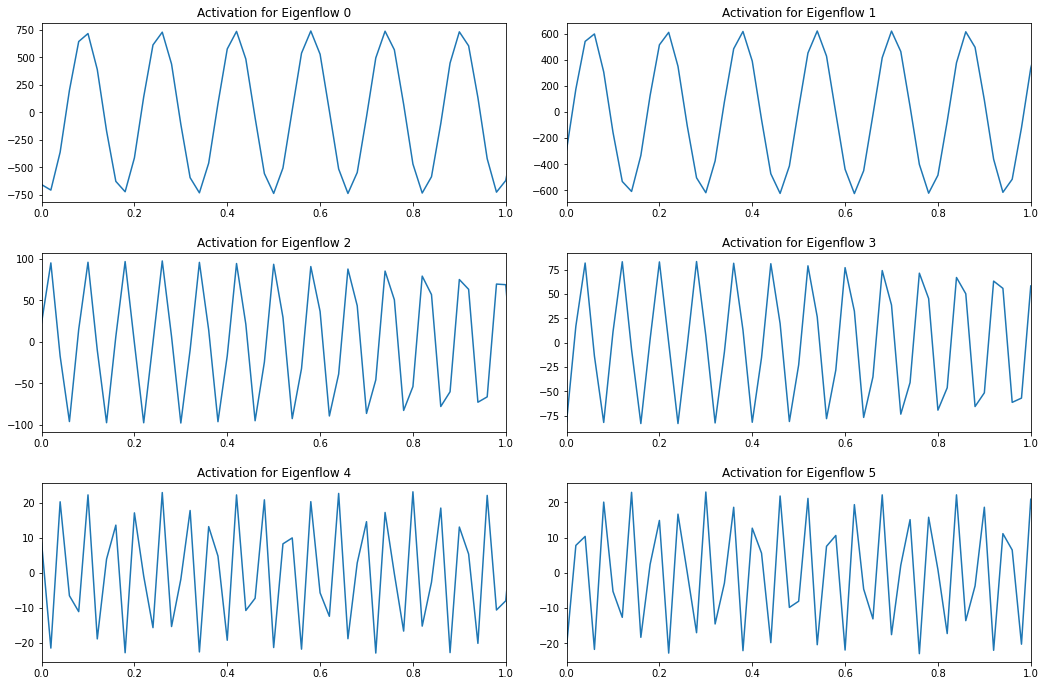

In [10]:
# Galerkin model based on discrete reconstruction as q = \bar{q}+\sum_i^n a_i(t)*\phi_i(x)
fig,ax = plt.subplots(3,2,figsize=(15,10))
fig.tight_layout(pad=3.0)

# add plots over full time domain
ax[0][0].plot(t,coeffs[0,:])
ax[0][1].plot(t,coeffs[1,:])
ax[1][0].plot(t,coeffs[2,:])
ax[1][1].plot(t,coeffs[3,:])
ax[2][0].plot(t,coeffs[4,:])
ax[2][1].plot(t,coeffs[5,:])

# set fixed time window to plot
ax[0][0].set_xlim([0,1])
ax[0][1].set_xlim([0,1])
ax[1][0].set_xlim([0,1])
ax[1][1].set_xlim([0,1])
ax[2][0].set_xlim([0,1])
ax[2][1].set_xlim([0,1])

# Set titles
ax[0][0].title.set_text("Activation for Eigenflow 0")
ax[0][1].title.set_text("Activation for Eigenflow 1")
ax[1][0].title.set_text("Activation for Eigenflow 2")
ax[1][1].title.set_text("Activation for Eigenflow 3")
ax[2][0].title.set_text("Activation for Eigenflow 4")
ax[2][1].title.set_text("Activation for Eigenflow 5")

# Computing Spatial Derivatives

In [11]:
# read su2 mesh file
mesh = meshio.read("./mesh_cylinder_lam.su2",file_format="su2")

# define mid point for rotational symmetric mesh
mid_point = np.array([0.5,0]) 

    Surface tag  cylinder will be replaced by 1
    Surface tag  farfield will be replaced by 2


In [12]:
derivs = custom_mesh(mesh,mid_point)

In [13]:
# q, q_avg, q_fluc
Qavg = derivs.compute_Q_operator(q_avg,q_avg)
Lavg = derivs.compute_L_operator(q_avg)

# Computing ODE Coefficients

In [14]:
# initialie arrays for parameters
b1 = np.empty(num)
b2 = np.empty(num)
L1 = np.empty((num,num))
L2 = np.empty((num,num))
Q = [np.empty((num,num)) for x in range(num)]

In [21]:
# defining parameter files
coef_dir = "./coefficients/"
b1_filename = coef_dir+"b1"
b2_filename = coef_dir+"b2"
L1_filename = coef_dir+"L1"
L2_filename = coef_dir+"L2"
Q_filename = coef_dir+"Q"

# set computation flag
compute_coefficients = False

if os.path.exists(b1_filename):
    b1 = np.load(b1_filename)
if os.path.exists(b2_filename):
    b2 = np.load(b2_filename)
if os.path.exists(L1_filename):
    L1 = np.load(L1_filename)
if os.path.exists(L2_filename):
    L2 = np.load(L2_filename)
if os.path.exists(Q_filename):
    Q = np.load(Q_filename) 

if compute_coefficients:
    for k in range(num):
        b1[k] = derivs.compute_inner_product(Lavg,U[:,k])
        b2[k] = derivs.compute_inner_product(Qavg,U[:,k])
        for i in tqdm(range(num)):
            Q_tmp1 = derivs.compute_Q_operator(q_avg,U[:,i])
            Q_tmp2 = derivs.compute_Q_operator(U[:,i],q_avg)
            L_tmp = derivs.compute_L_operator(U[:,i])
            L1[k,i] = derivs.compute_inner_product(L_tmp,U[:,k])
            L2[k,i] = derivs.compute_inner_product(Q_tmp1+Q_tmp2,U[:,k])
            for j in range(num):
                Q_tmp3 = derivs.compute_Q_operator(U[:,i],U[:,j])
                Q[k][i,j] = derivs.compute_inner_product(Q_tmp3,U[:,k])
        
    # saving coefficient arrays to files
    np.save(b1_filename,b1)
    np.save(b2_filename,b2)
    np.save(L1_filename,L1)
    np.save(L2_filename,L2)
    np.save(Q_filename,Q)


# Solving Galerkin ODE System

In [16]:
# initial conditions for the activations are obtained as activations on the initial timeframe of the data matrix
a0 = coeffs[:,0] #initial conditions
dt = 0.01 * subsampling
t0 = 0
tmax = max_size * 0.01 * subsampling
sampling_span = np.linspace(t0,tmax,num=max_size+1)
# static viscosity
nu = 1.516e-5

# defining ode function
def galerkin_system(t,a):
    # set global variables references
    global Q, L1, L2, b1, b2, nu
    a_dot = np.empty_like(a)
    for k in range(a_dot.shape[0]):
        # the vector notation makes np.matmul automatically reduce to a one dimensional output therefore normal multiplication can be used to get vector shape
        # the indexed vectors L1 and L2 form columnvectors (automatically)
        a_dot[k] = nu * b1[k] + b2[k] + np.matmul((nu*L1[k,:]+L2[k,:]),a) + np.matmul(np.matmul(np.expand_dims(a,1).T,Q[k]),np.expand_dims(a,1))
    return a_dot.flatten()

# euler-forward ode
def euler_galerkin_system(dt,ak):
    # set global variables references
    global Q, L1, L2, b1, b2, nu
    akp1 = np.empty_like(ak)
    for k in range(akp1.shape[0]):
        # the vector notation makes np.matmul automatically reduce to a one dimensional output therefore normal multiplication can be used to get vector shape
        # the indexed vectors L1 and L2 form columnvectors (automatically)
        akp1[k] = ak[k] + dt * (nu * b1[k] + b2[k] + np.matmul((nu*L1[k,:]+L2[k,:]),ak) + np.matmul(np.matmul(np.expand_dims(ak,1).T,Q[k]),np.expand_dims(ak,1)))
    return akp1.flatten()    

from scipy.integrate import solve_ivp
t0 = 0
scaling_factor = 1
tmax = max_size * 0.01 * subsampling * scaling_factor
sampling_span = np.linspace(t0,tmax,num=max_size+1)
sol = solve_ivp(galerkin_system,(t0,tmax),a0,method='RK45',first_step=1)

In [17]:
# parameters
a0 = coeffs[:,0] #initial conditions
dt = 0.01 * subsampling
t = 0
t0 = 0
tmax = max_size * dt
sampling_span = np.linspace(t0,tmax,num=max_size+1)

# coefficient matrix
galerkin_activations = np.empty_like(coeffs)
galerkin_activations[:,0] = a0
# solver iteration

for i in range(1,max_size):
    galerkin_activations[:,i] = euler_galerkin_system(dt,galerkin_activations[:,i-1])
    t+=dt

<ipython-input-16-ff2056f7625c>:29: RuntimeWarning: overflow encountered in matmul
  akp1[k] = ak[k] + dt * (nu * b1[k] + b2[k] + np.matmul((nu*L1[k,:]+L2[k,:]),ak) + np.matmul(np.matmul(np.expand_dims(ak,1).T,Q[k]),np.expand_dims(ak,1)))
<ipython-input-16-ff2056f7625c>:29: RuntimeWarning: invalid value encountered in matmul
  akp1[k] = ak[k] + dt * (nu * b1[k] + b2[k] + np.matmul((nu*L1[k,:]+L2[k,:]),ak) + np.matmul(np.matmul(np.expand_dims(ak,1).T,Q[k]),np.expand_dims(ak,1)))


# To Do:
- Streamline computation of Q and L - done
- add flag to derivations for first and second derivative - done
- find solution to fix point data -> cell data being more transparent
- compute matrix of L and Q entries - done?
- setup the ODE system with computed factors - done
- find ODE solver (Matlab ode45 ?) or implement own
- add cell derivative scheme as comparison
...

# Testing and Validation

In [18]:
# derivs = custom_mesh(mesh,mid_point)

# rho_arr     # density
# p_arr       # pressure
# vort_arr    # vorticity
# e_arr       # energy
# u_arr       # velocity in x
# v_arr       # velocity in y


# q_fluc & q_avg
# get all node indexes of cylinder surface
wall_radius = derivs.rads[0]
cylinder_wall = derivs.points_sc[:,0]==wall_radius
cylinder_wall_indexes = np.where(cylinder_wall==True)[0]   
# get all node indexes of farfield surface
farfield_radius = derivs.rads[-1]
farfield = derivs.points_sc[:,0]==farfield_radius
farfield_indexes = np.where(farfield==True)[0] 
# -> first 200 points are cylinder wall -> last 200 are farfield boundary
[dx,dy,ddx,ddy] = derivs.compute_derivatives(q_fluc[:,0])

In [20]:
print(dx.max(),dy.max(),ddx.min(),ddy.min()) # ergibt unrealistische Zahlen

84.51116524558697 62.680799433028525 -1801.770577256168 -4550.39298341933


# Zell basierte lineare Interpolation